# Expected Pass (xP)

Импортируем нужные библиотеки

In [17]:
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import numpy as np
import sklearn as skl
from matplotlib import pylab as plot
%pylab inline

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

Populating the interactive namespace from numpy and matplotlib


Загружаем данные для обучения и для предсказания

In [19]:
data = pd.read_csv('data/df_events_epl_train.csv')
data_for_prediction = pd.read_csv('data/df_events_bundes_test.csv')
len(data), len(data_for_prediction)

(1335409, 276815)

### Обработка данных

Преобразуем данные перед обучением

In [20]:
# process train data before fitting
def process_train_data(df):
    # drop data with specific pass_outcome_name and pass_type_name
    df.drop(df[df['pass_outcome_name'].isin(['Pass Offside', 
                                             'Injury Clearance', 
                                             'Unknown'])].index, inplace=True)
    df.drop(df[df['pass_outcome_name'].isin(['Kick Off',
                                             'Throw-in', 
                                             'Goal Kick',
                                             'Free Kick', 
                                             'Corner'])].index, inplace=True)
    # drop data with non-pass action
    df = df[df['type_name'] == 'Pass']
    # drop data with incorrect pass outcome
    df.dropna(subset=['outcome_binary'], inplace=True)
    
    # take only useful for building model columns
    df = df[['location_0',
             'location_1',
             'pass_end_location_0',
             'pass_end_location_1',
             'pass_length',
             'pass_angle',
             'pass_height_name',
             'pass_body_part_name',
             'duration',
             'under_pressure',
             'outcome_binary']]
    return df


data = process_train_data(data)

Делим данные для обучения на обучающую и тренировочную выборку

In [27]:
# split data on features and targets
X = data[['location_0',
          'location_1',
          'pass_end_location_0',
          'pass_end_location_1',
          'pass_length',
          'pass_angle',
          'pass_height_name',
          'pass_body_part_name',
          'duration',
          'under_pressure']]
y = data[['outcome_binary']]

# one-hot encoding
X = pd.get_dummies(X)

# add passing speed
X['pass_speed'] = X.apply(lambda x: x['pass_length'] / x['duration'], axis=1)


len(X), len(y)

(378181, 378181)

In [28]:
from sklearn.model_selection import train_test_split

# split data on train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=777)
len(X_train), len(y_train), len(X_test), len(y_test)

(302544, 302544, 75637, 75637)

### Обучение модели

Функция, выполняющая обучение

In [45]:
from sklearn import metrics

def modelfit(alg, X_train, y_train, X_test, y_test, 
             cross_validation=True, cv_folds=5, early_stopping_rounds=50):
    
    if cross_validation:
        xgb_param = alg.get_xgb_params()
        xg_train = xgb.DMatrix(X_train.values, label=y_train.values)
        xg_test = xgb.DMatrix(X_test.values)
        # cross-validation
        cv_result = xgb.cv(xgb_param, xg_train, 
                          num_boost_round=alg.get_params()['n_estimators'], 
                          nfold=cv_folds,
                          metrics='auc', 
                          early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cv_result.shape[0])
    
    # fit the algorithm on the data
    alg.fit(X_train, y_train, eval_metric='auc')
        
    # predict training set
    dtrain_predictions = alg.predict(X_train)
    dtrain_predprob = alg.predict_proba(X_train)[:, 1]
        
    # print model report
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(y_train.values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(y_train, dtrain_predprob))
    
    # predict on testing data
    prediction = alg.predict_proba(X_test)[:, 1]
    print('AUC Score (Test): %f' % metrics.roc_auc_score(y_test, prediction))
    
    # feature importance
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

Подбираем параметры: так как выборка несбалансированная нужно установить параметр `scale_pos_weight`

In [39]:
weight_balance = len(y_train[y_train['outcome_binary'] == 0]) / len(y_train[y_train['outcome_binary'] == 1])

Ниже представлены 3 модели, на которых при подборе гиперпараметров были наибольшие точности. Наибольшую точность даёт модель `xgb1`


Model Report
Accuracy : 0.8756
AUC Score (Train): 0.950524
AUC Score (Test): 0.935718


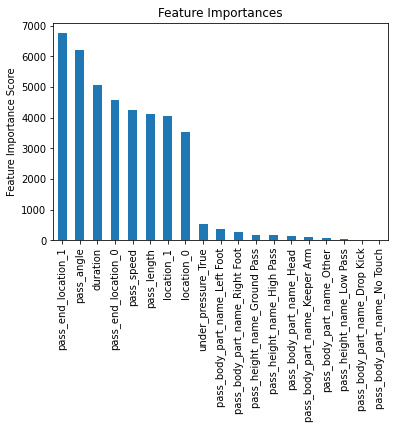

In [40]:
xgb0 = XGBClassifier(
        learning_rate=0.05,
        max_depth=10, # depth of trees
        n_estimators=150, # amount of trees
        objective='binary:logistic', # binary function
        scale_pos_weight=weight_balance, # balance of positive and negative weights
        subsample=0.8, # subsample ratio of the training instances
        seed=77
)
modelfit(xgb0, X_train, y_train, X_test, y_test)


Model Report
Accuracy : 0.8842
AUC Score (Train): 0.958650
AUC Score (Test): 0.935774


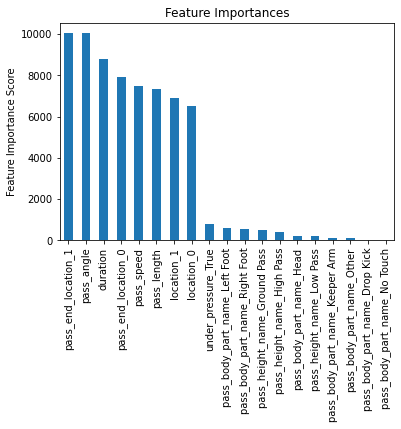

In [49]:
xgb1 = XGBClassifier(
        learning_rate=0.05,
        max_depth=10, # depth of trees
        n_estimators=300, # amount of trees
        objective='binary:logistic', # binary function
        scale_pos_weight=weight_balance, # balance of positive and negative weights
        subsample=0.8, # subsample ratio of the training instances
        seed=77
)
modelfit(xgb1, X_train, y_train, X_test, y_test)


Model Report
Accuracy : 0.871
AUC Score (Train): 0.945815
AUC Score (Test): 0.936014


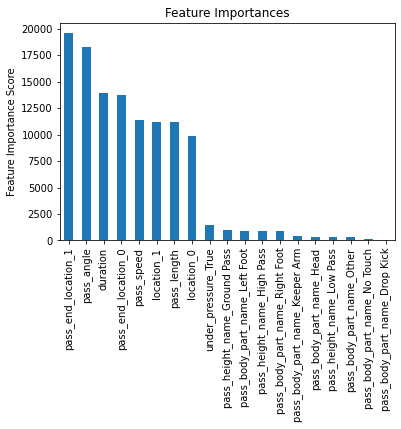

In [59]:
xgb2 = XGBClassifier(
        learning_rate=0.01,
        max_depth=8, # depth of trees
        n_estimators=1000, # amount of trees
        objective='binary:logistic', # binary function
        scale_pos_weight=weight_balance, # balance of positive and negative weights
        subsample=0.7, # subsample ratio of the training instances
        seed=77
)
modelfit(xgb2, X_train, y_train, X_test, y_test)

### Получение предсказания

In [64]:
data_for_id = pd.read_csv('data/sample_submission.csv')
data_for_prediction = data_for_prediction[data_for_prediction['id'].isin(data_for_id['id'])]

X_pred = data_for_prediction[[
    'location_0',
    'location_1',
    'pass_end_location_0',
    'pass_end_location_1',
    'pass_length',
    'pass_angle',
    'pass_height_name',
    'pass_body_part_name',
    'duration',
    'under_pressure']]
X_pred = pd.get_dummies(X_pred)
X_pred['pass_speed'] = X_pred.apply(lambda x: x['pass_length'] / x['duration'], axis=1)

predict = xgb1.predict_proba(X_pred)[:, 1]

len(predict)

68149

In [65]:
result = pd.DataFrame({'id': data_for_prediction['id'], 'outcome_binary': predict})

result

,id,outcome_binary
7,9026a8bb-8fd6-4b44-b2aa-28356a8950e9,0.112681
12,e4e7f3d3-1529-48a8-824e-43ff2d13fbe3,0.644841
15,03cfd6b9-06c2-4597-bab3-baf1df24ab5a,0.189219
17,72a34c8a-203a-41bc-93e0-b830485c07ef,0.679029
21,18afe4b5-1e64-41a4-8f7a-96c5bb761450,0.009531
...,...,...
276793,d134dff0-e453-42bc-a42d-342b3f12f526,0.975305
276796,9f9d3d38-20c0-46f6-9c97-5b423de13166,0.863834
276799,8345f6cb-7f8b-4034-bd75-ca49b3a16bd5,0.991653
276803,a6df9cad-b750-4bdf-8c19-0d40476a52fe,0.045399


In [66]:
# sort the result in ascending order of id 
result = result.sort_values(by='id')
result

,id,outcome_binary
30907,00008169-659b-46c5-be86-a15b8068ef05,0.013783
217239,0000c881-3d53-4c2f-86bb-542b653591ae,0.509599
142929,00010f78-4407-4e0c-b59e-a33f3b86af1f,0.928264
206533,000186c5-94e1-46ab-90b8-4b20ba319d1b,0.959541
140633,0002d42e-6214-48fa-ba7d-2ade486dcd27,0.034230
...,...,...
168732,fffbc079-230d-4eb6-b713-9509b07dd02d,0.761499
221509,fffce801-575e-4f51-8411-5fa1a338360d,0.566075
163765,fffd0d33-a248-4fc8-8ef0-edaa4d4cc217,0.930681
151643,fffd4e83-cae7-4146-8729-ab37a74f7e18,0.211819


In [67]:
# save the prediction
result.to_csv("prediction/prediction_probability.csv", index=False)